In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [127]:
import skimage
import sklearn
import matplotlib.pyplot as plt

In [128]:
import cv2
import os
import PIL

In [129]:
import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, RandomResizedCrop, RandomGrayscale, RandomHorizontalFlip, GaussianBlur, ColorJitter, RandomSolarize, ToPILImage, ToTensor, RandomCrop, CenterCrop, Resize

# set torch seed for reproducibility when using random image augmentations
torch.manual_seed(0)

In [130]:
from src.dataset import OurPatchLocalizationDataset, OriginalPatchLocalizationDataset

## Helper Functions

In [46]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def load_tiny_imagenet(tiny_imagenet_folder, dataset_type='train', transform=transforms.ToPILImage()):
    images = []
    if dataset_type == 'train':
        for foldername in tqdm(os.listdir(os.path.join(tiny_imagenet_folder, dataset_type))):
            for filename in os.listdir(os.path.join(tiny_imagenet_folder, dataset_type, foldername, "images")):
                img = cv2.imread(os.path.join(tiny_imagenet_folder, dataset_type, foldername, "images", filename))
                if img is not None:
                    images.append(transform(img) if transform else img)
    else:
        # 'val' or 'test'
        for filename in tqdm(os.listdir(os.path.join(tiny_imagenet_folder, dataset_type, "images"))):
            img = cv2.imread(os.path.join(tiny_imagenet_folder, dataset_type, "images", filename))
            if img is not None:
                images.append(transform(img) if transform else img)
    
    return images

def image_to_patches(img):
    """Crop split_per_side x split_per_side patches from input image.
    Args:
        img (PIL Image): input image.
    Returns:
        list[PIL Image]: A list of cropped patches.
    """
    splits_per_side = 3  # split of patches per image side
    h, w = img.size()[1:]
    h_grid = h // splits_per_side
    w_grid = w // splits_per_side
    
    patches = [
        TF.crop(img, i * h_grid, j * w_grid, h_grid, w_grid)
        for i in range(splits_per_side) 
        for j in range(splits_per_side)
    ]
    
    return patches

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Load Data

In [131]:
tiny_imagenet = load_tiny_imagenet("./data/tiny-imagenet-200", dataset_type='val', transform=transforms.Compose([transforms.ToPILImage(), transforms.Resize(224)]))

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1934.77it/s]


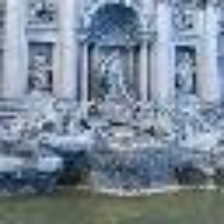

In [132]:
tiny_imagenet[100]

## Experiments

In [47]:
# transform that will be applied to every raw image
TINY_IMAGENET_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# random augmentations
AUGMENTATIONS = [
    RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    RandomGrayscale(p=0.5),
    GaussianBlur(kernel_size=23, sigma=(0.1, 0.2)),
    RandomSolarize(192, p=0.5),
]

In [65]:
img = ToTensor()(tiny_imagenet[0])

In [ ]:
t = RandomCrop(patch_size)

In [ ]:
def get_patch(img, pos=(1, 1)):
    s = img.size()[-1]
    patch_size = s // 4
    grid_size = s // 3
    row, col = pos
    t = RandomCrop(patch_size)
    if col == 0:
        img, row * grid, col * grid, grid, grid

In [83]:
splits_per_side = 3
h, w = img.size()[1:]
patch_size = h // 4
t = RandomCrop(patch_size)
grid = h // 3
patches = [
    t(TF.crop(img, row * grid, col * grid, grid, grid))
    for row in range(splits_per_side)
    for col in range(splits_per_side)
]

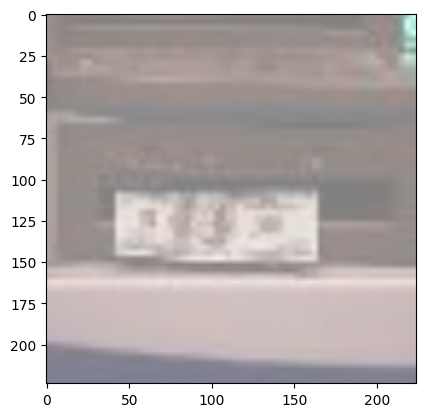

In [84]:
imshow(img)

56


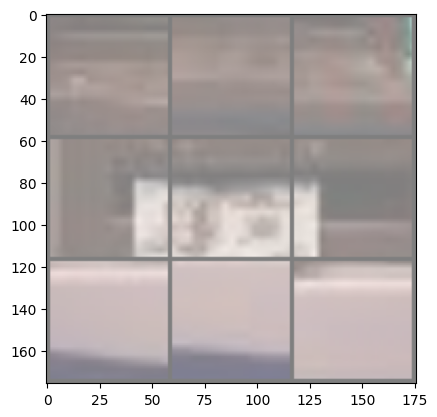

In [95]:
imshow(torchvision.utils.make_grid(image_to_patches(img), nrow=3))

In [119]:
def image_to_patches(img):
    """Crop split_per_side x split_per_side patches from input image.
    Args:
        img (Tensor image): input image.
    Returns:
        list[Tensor image]: A list of cropped patches.
    """
    splits_per_side = 3  # split of patches per image side
    img_size = img.size()[-1]
    grid_size = img_size // splits_per_side
    patch_size = img_size // 4
    
    # we first use a center crop (to ensure gap) followed by a random crop (jitter) followed by resize (to ensure img_size stays the same)
    random_jitter = Compose([CenterCrop(grid_size-patch_size//4), RandomCrop(patch_size), Resize(img_size)]) 
    patches = [
        random_jitter(TF.crop(img, i * grid_size, j * grid_size, grid_size, grid_size))
        for i in range(splits_per_side)
        for j in range(splits_per_side)
    ]

    return patches

class OrigPatchLocalizationDataset(torch.utils.data.Dataset):
    """
    Dataset implementing the original Patch Localization method
    A sample is made up of the 8 possible tasks for a given grid ((center, neighbor), labels)
    """

    def __init__(self, data_source, transform=None, samples_per_image=8):
        
        self.data_source = data_source
        self.transform = transform if transform else TINY_IMAGENET_TRANSFORM
        self.samples_per_image = samples_per_image

    def __len__(self):
        return len(self.data_source)

    def __getitem__(self, idx):
        img = self.data_source[idx]

        img = self.transform(img)
        
        samples = self.image_to_samples(img)
        
        return samples
    
    def image_to_samples(self, img):
        # convert image into patches
        patches = image_to_patches(img)
        # randomly select n_samples from all possible labels without replacement
        labels = np.random.choice(8, self.samples_per_image)

        samples = []
        for label in labels:
            if label >= 4:
                # the middle patch (number 4) is never a neighbor 
                label += 1
            samples.append(torch.stack((patches[4], patches[label])))

        return (torch.stack(samples), torch.from_numpy(labels))
    
class OPatchLocalizationDataset(OrigPatchLocalizationDataset):
    """
    Dataset implementing our modified Patch Localization method
    A sample is made up of the 8 possible tasks for a given grid ((center, random_aug(neighbor), random_aug(neighbor)), labels)
    """

    def __init__(self, data_source, transform=None, samples_per_image=8, aug_transforms=None):
        super(OurPatchLocalizationDataset, self).__init__(data_source, transform, samples_per_image)

        self.aug_transform = Compose(aug_transforms) if aug_transforms else Compose(RELIC_AUGMENTATIONS)
    
    def image_to_samples(self, img):
        # convert image into patches
        patches = image_to_patches(img)
        # randomly select n_samples from all possible labels without replacement
        labels = np.random.choice(8, self.samples_per_image)

        samples = []
        for label in labels:
            if label >= 4:
                # the middle patch (number 4) is never a neighbor 
                label += 1
            samples.append(torch.stack((patches[4], self.aug_transform(patches[label]), self.aug_transform(patches[label]))))

        return (torch.stack(samples), torch.from_numpy(labels))
        
        
    def generate_perms(self, patches):
        # randomly transform outer patch in two different ways
        return [
            torch.cat((TF.resize(patches[4], 224), self.aug_transform(patches[i]), self.aug_transform(patches[i])), dim=0)
            for i in range(9) if i != 4
        ]
        

In [101]:
def image_to_samples(img, n_samples=8):
    # convert image into patches
    patches = image_to_patches(img)
    # randomly select n_samples from all possible labels without replacement
    labels = np.random.choice(8, n_samples)
    
    samples = []
    for label in labels:
        if label >= 4:
            # the middle patch (number 4) is never a neighbor 
            label += 1
        samples.append(torch.stack(patches[4], patches[label]))
    
    return (torch.stack(samples), torch.from_numpy(labels))
    
    
    
def image_to_patches(img):
    """Crop split_per_side x split_per_side patches from input image.
    Args:
        img (PIL Image): input image.
    Returns:
        list[PIL Image]: A list of cropped patches.
    """
    splits_per_side = 3  # split of patches per image side
    img_size = img.size()[-1]
    grid_size = img_size // splits_per_side
    patch_size = img_size // 4
    
    random_jitter = Compose([CenterCrop(grid_size-patch_size//4), RandomCrop(patch_size)]) 
    patches = [
        random_jitter(TF.crop(img, i * grid_size, j * grid_size, grid_size, grid_size))
        for i in range(splits_per_side)
        for j in range(splits_per_side)
    ]

    return patches

In [ ]:
def image_to_patches(img):
    """Crop split_per_side x split_per_side patches from input image.
    Args:
        img (PIL Image): input image.
    Returns:
        list[PIL Image]: A list of cropped patches.
    """
    splits_per_side = 3  # split of patches per image side
    h, w = img.size()[1:]
    h_grid = h // splits_per_side
    w_grid = w // splits_per_side

    patches = [
        TF.crop(img, i * h_grid, j * w_grid, h_grid, w_grid)
        for i in range(splits_per_side)
        for j in range(splits_per_side)
    ]

    return patches

class OrigPatchLocalizationDataset(torch.utils.data.Dataset):
    """
    Dataset implementing the original Patch Localization method
    A sample is made up of the 8 possible tasks for a given grid ((center, neighbor), labels)
    """

    def __init__(self, data_source, transform=None):
        self.data_source = data_source
        self.transform = transform if transform else TINY_IMAGENET_TRANSFORM

    def __len__(self):
        return len(self.data_source)

    def __getitem__(self, idx):
        img = self.data_source[idx]

        img = self.transform(img)
        # split image into 9 patches
        patches = image_to_patches(img)
        # generate the permutations between the patches
        perms = self.generate_perms(patches)
        # labels for patch pairs
        patch_labels = torch.LongTensor(list(range(8)))

        samples = (torch.stack(perms), patch_labels)
        return samples

    def generate_perms(self, patches):
        return [torch.cat((patches[4], patches[i]), dim=0) for i in range(9) if i != 4]


class OrPatchLocalizationDataset(OrigPatchLocalizationDataset):
    """
    Dataset implementing our modified Patch Localization method
    A sample is made up of the 8 possible tasks for a given grid ((center, random_aug(neighbor), random_aug(neighbor)), labels)
    """

    def __init__(self, data_source, transform=None, aug_transforms=None):
        super(OurPatchLocalizationDataset, self).__init__(data_source, transform)

        self.aug_transform = Compose(aug_transforms) if aug_transforms else Compose(RELIC_AUGMENTATIONS)

    def generate_perms(self, patches):
        # randomly transform outer patch in two different ways
        return [
            torch.cat((TF.resize(patches[4], 224), self.aug_transform(patches[i]), self.aug_transform(patches[i])), dim=0)
            for i in range(9) if i != 4
        ]

In [139]:
ds = OurPatchLocalizationDataset(tiny_imagenet)

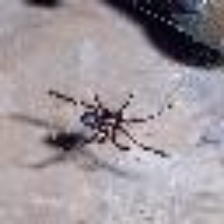

In [137]:
tiny_imagenet[1100]

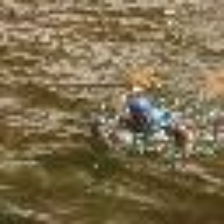

In [141]:
tiny_imagenet[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


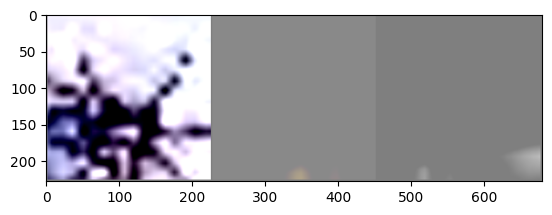

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


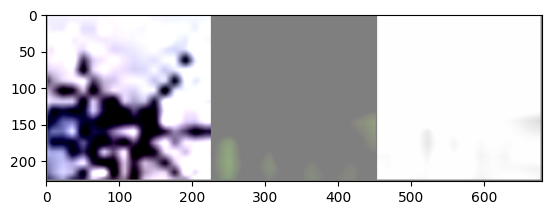

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


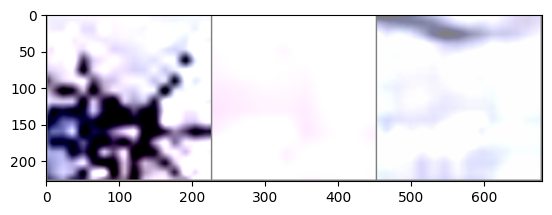

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


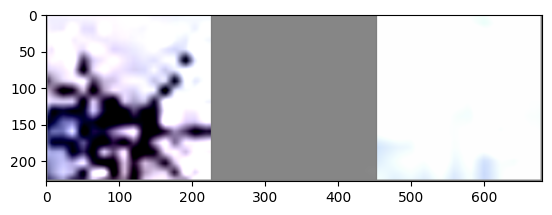

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


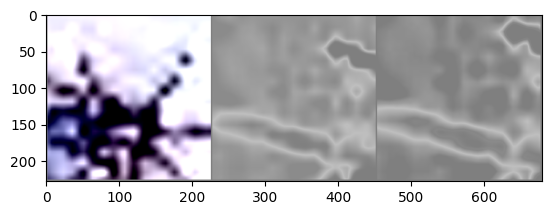

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


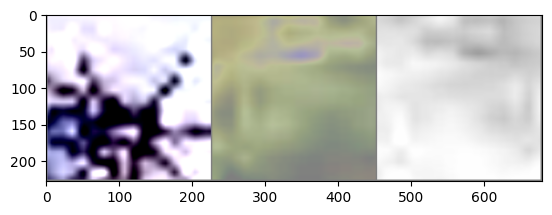

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


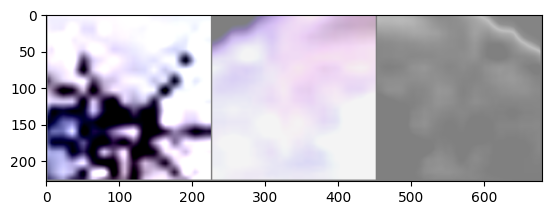

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


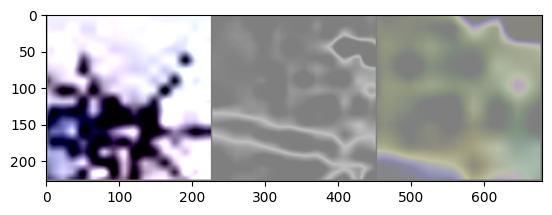

In [142]:
for imgs in ds[1100][0]:
    imshow(torchvision.utils.make_grid(imgs))

In [100]:
dl = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 8, 2, 3, 21, 21])
tensor([[0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7]])


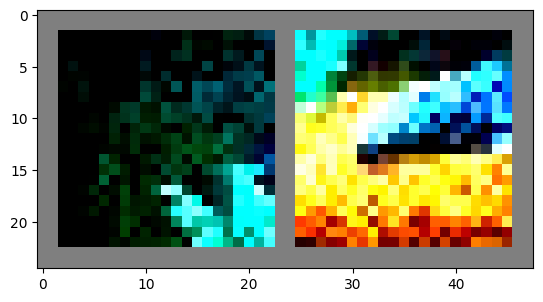

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


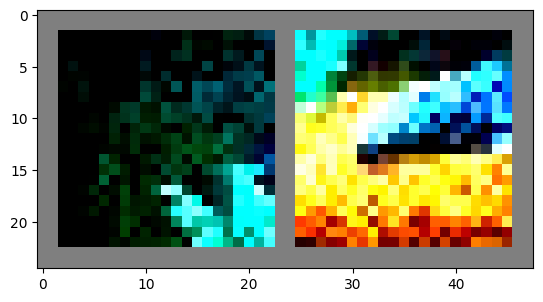

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


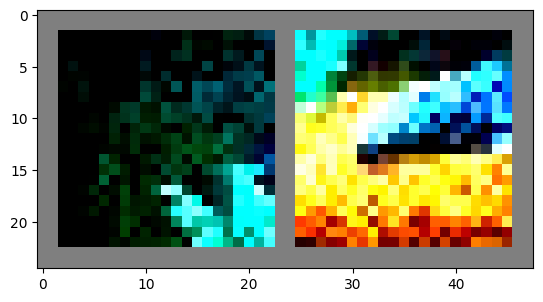

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


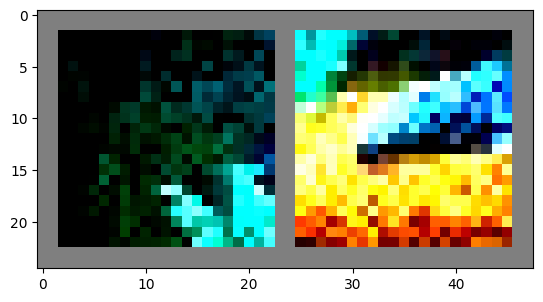

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


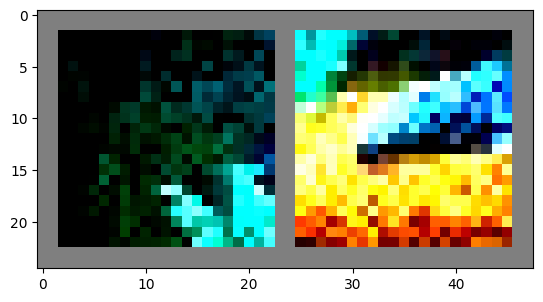

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


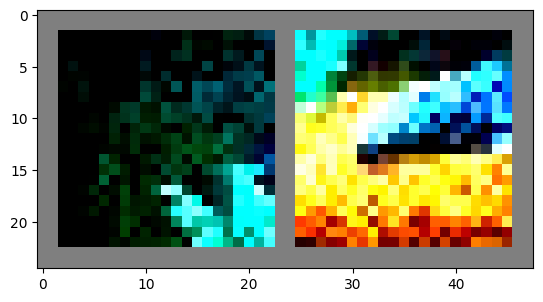

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


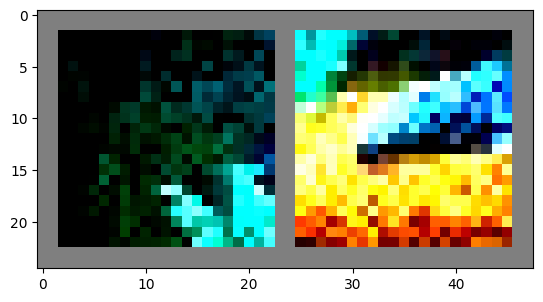

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


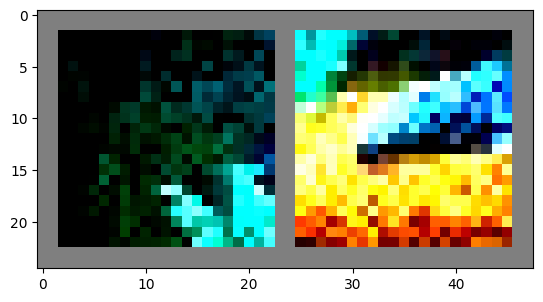

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


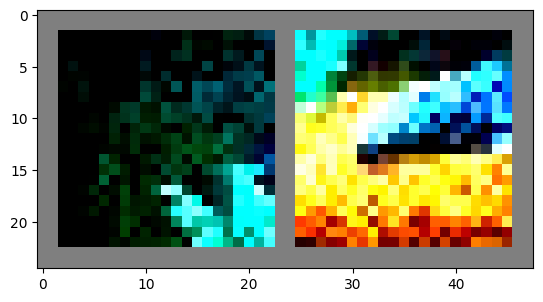

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


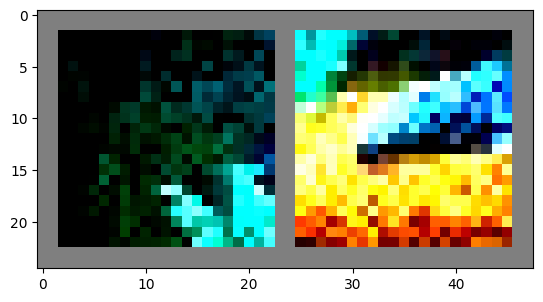

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


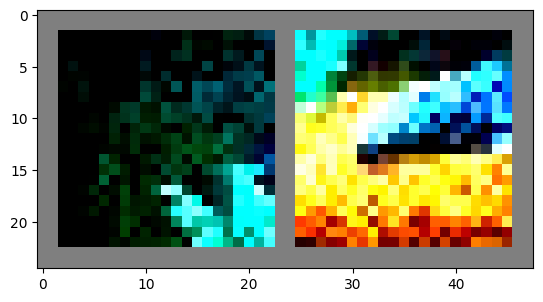

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


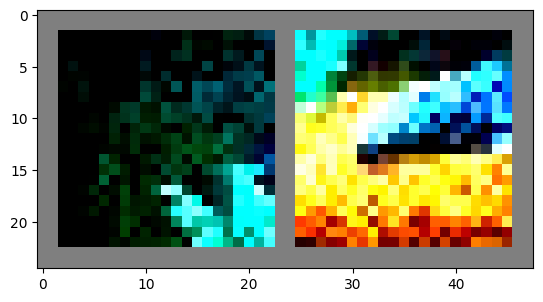

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


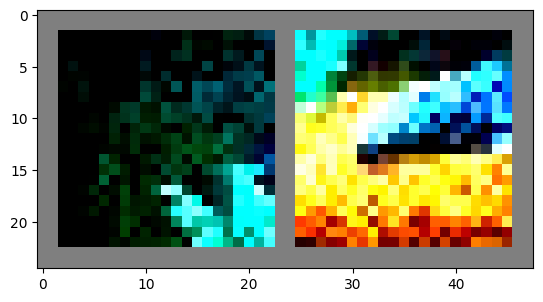

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


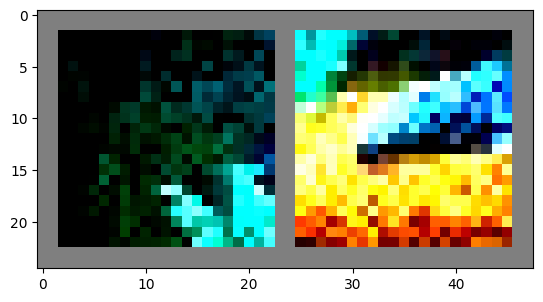

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


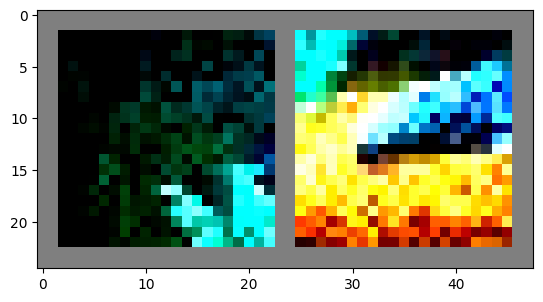

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


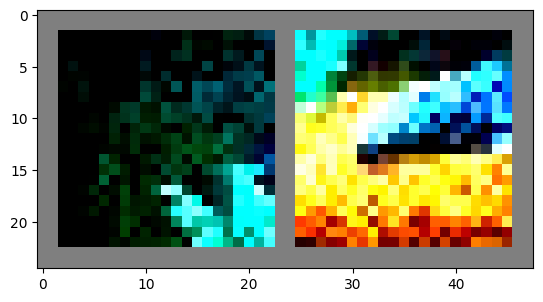

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


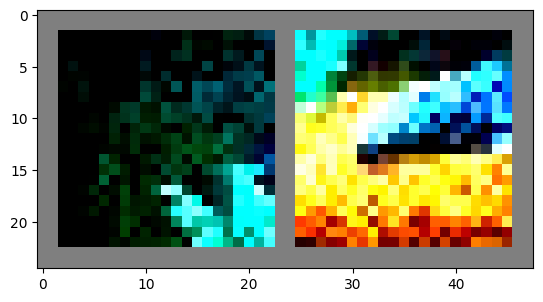

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


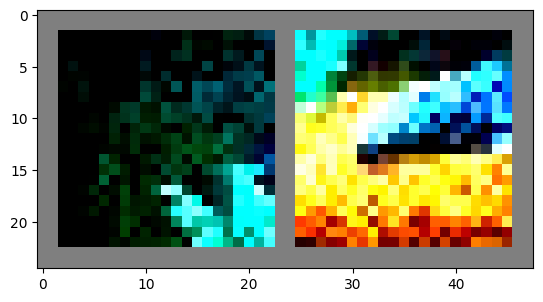

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


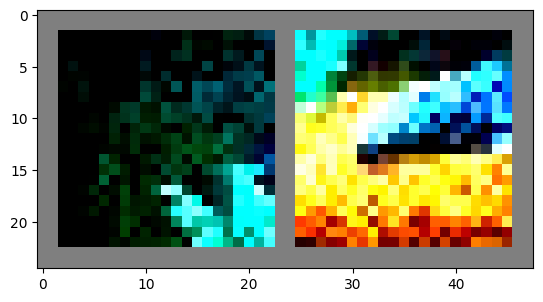

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


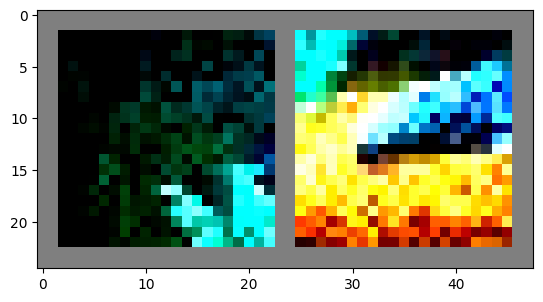

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


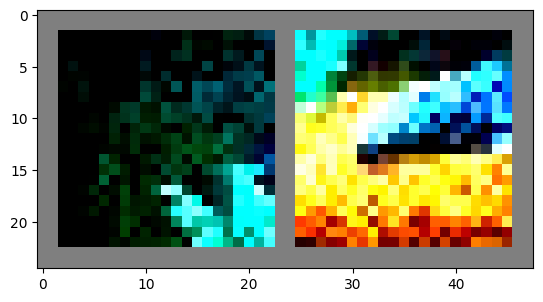

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


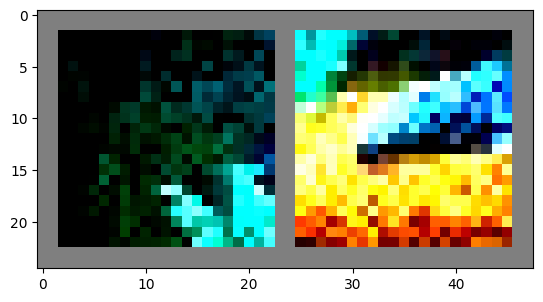

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


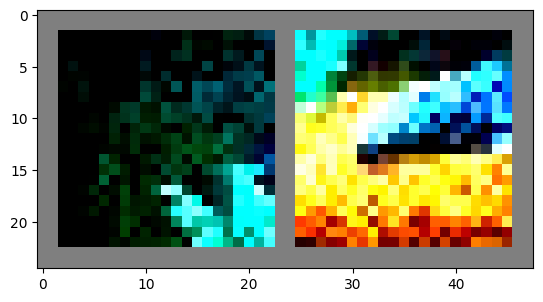

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


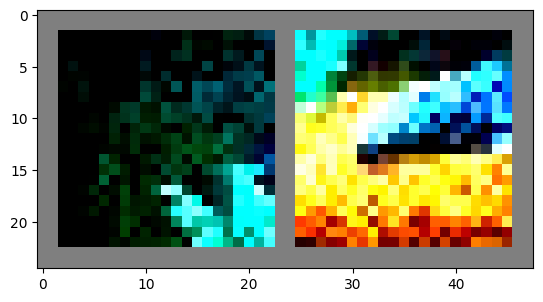

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


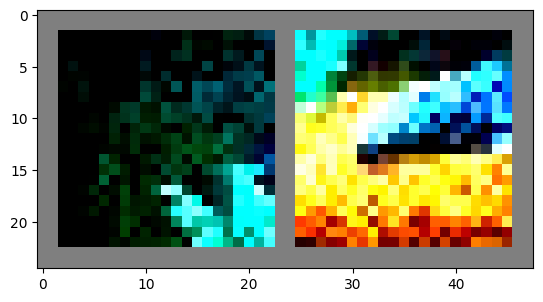

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


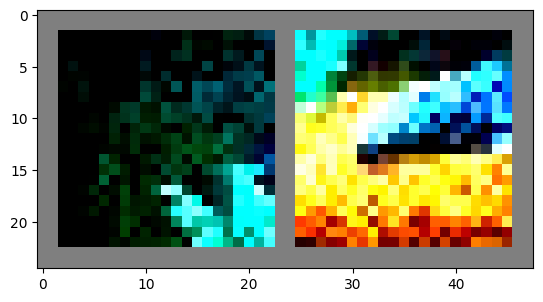

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


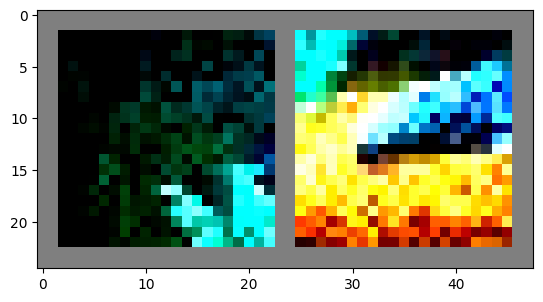

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


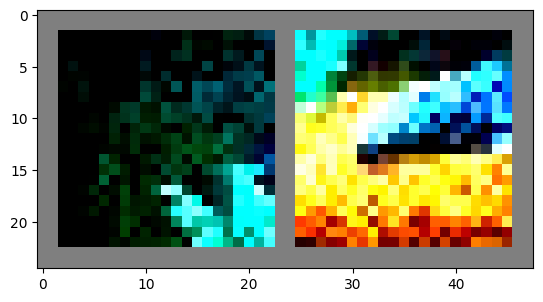

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


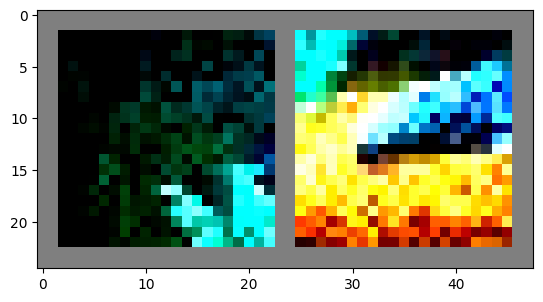

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


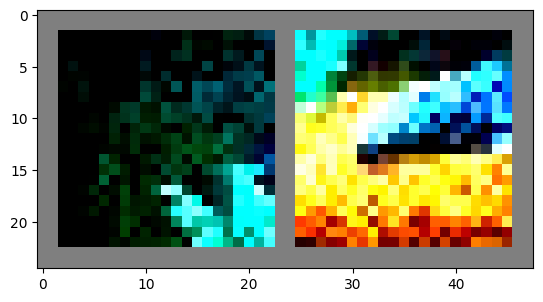

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


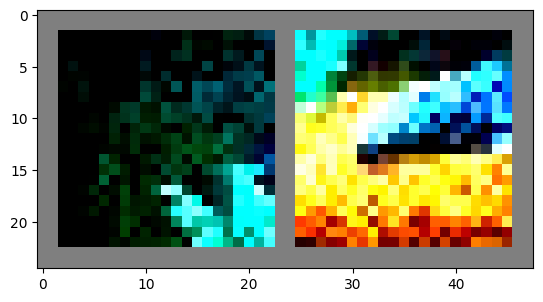

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


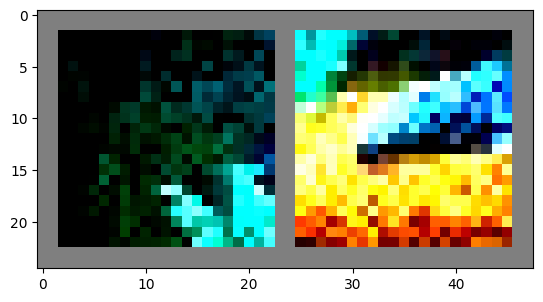

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


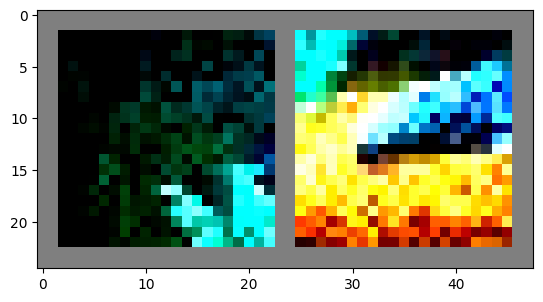

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


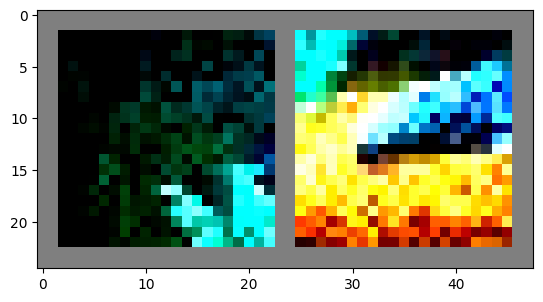

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


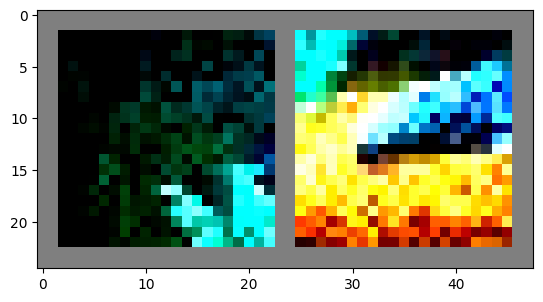

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


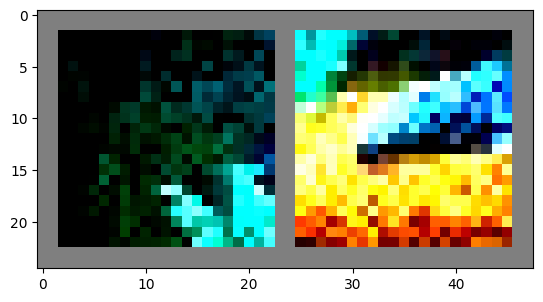

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


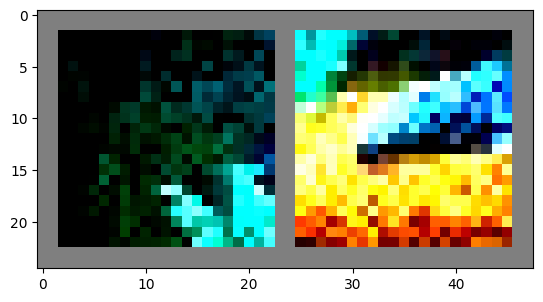

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


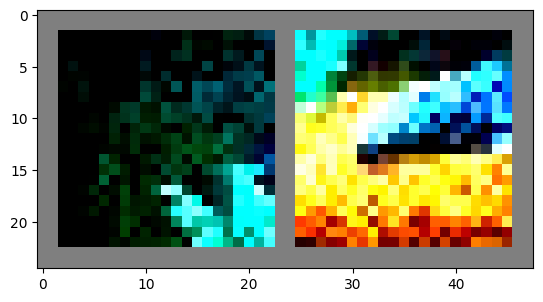

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


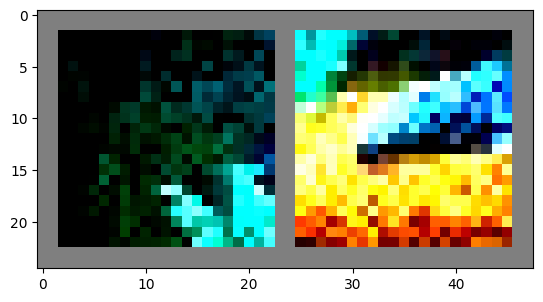

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


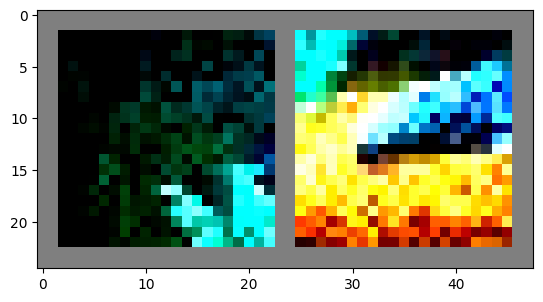

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


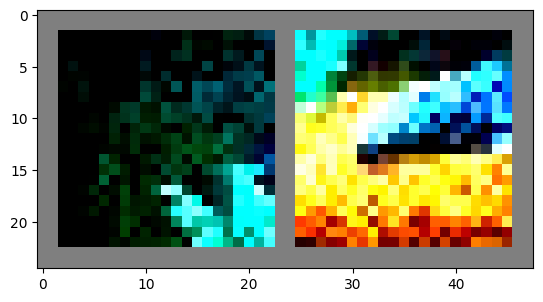

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


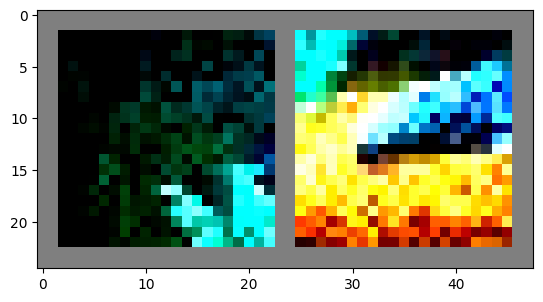

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


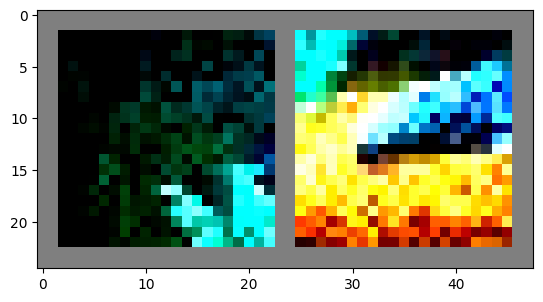

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


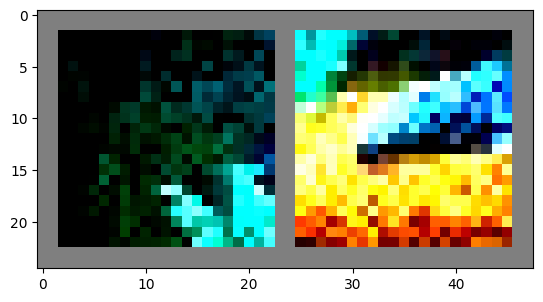

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


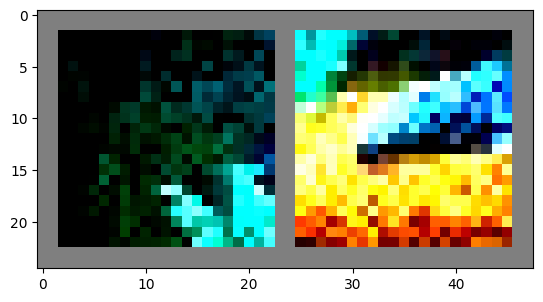

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


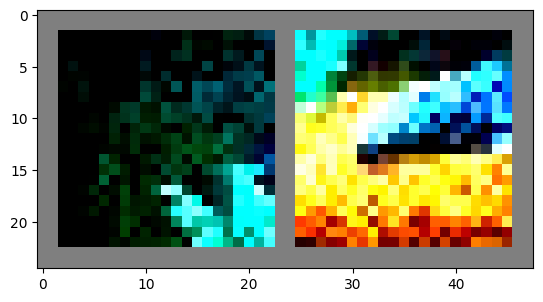

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


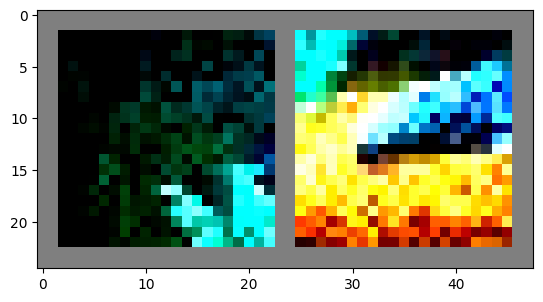

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


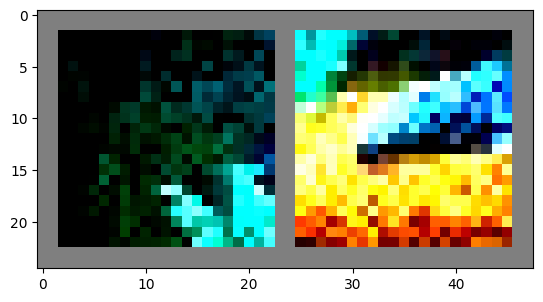

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


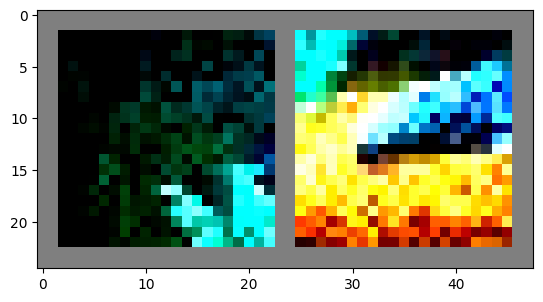

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


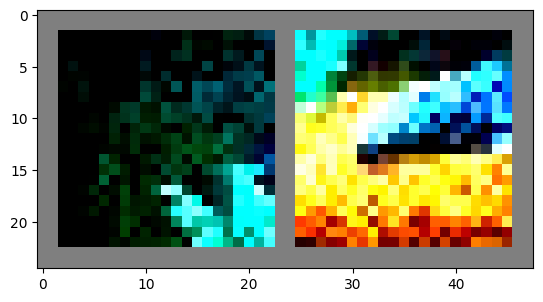

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


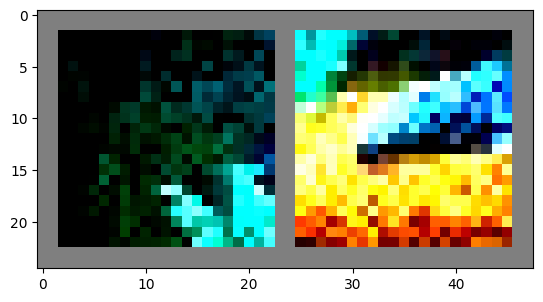

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


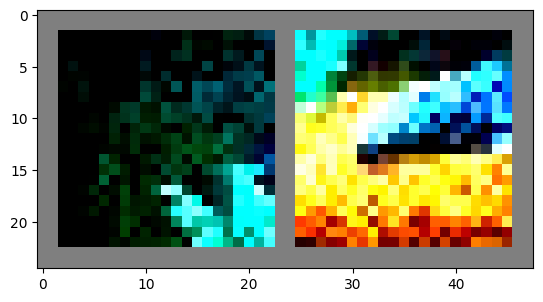

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


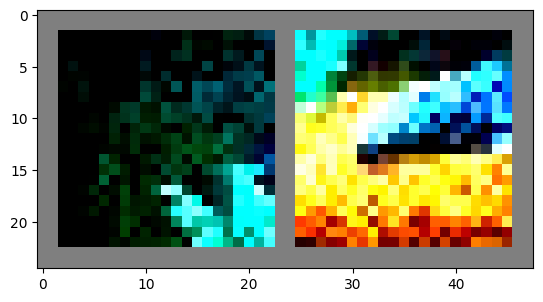

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


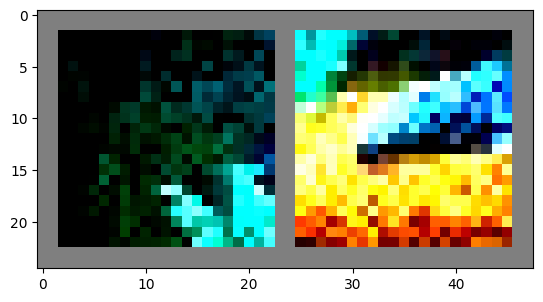

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


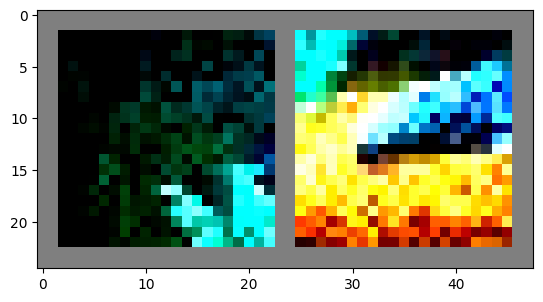

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


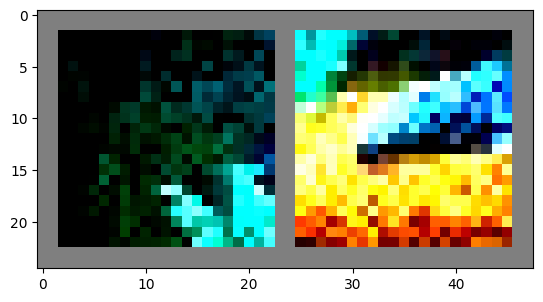

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


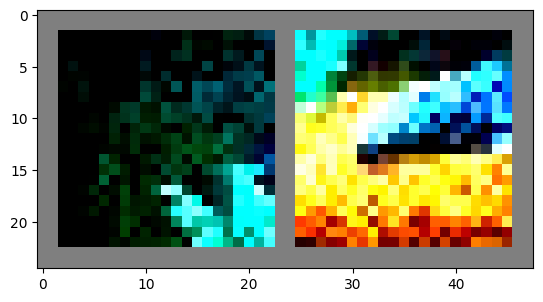

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


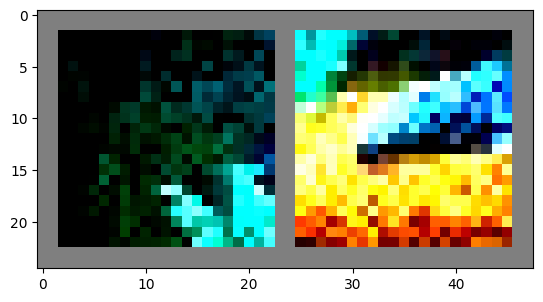

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


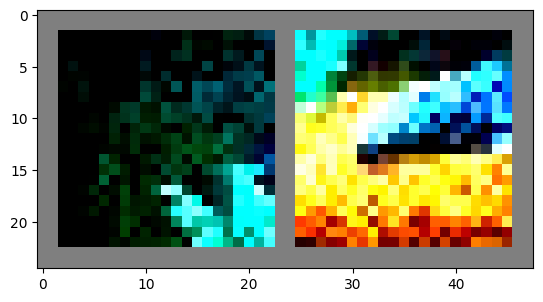

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


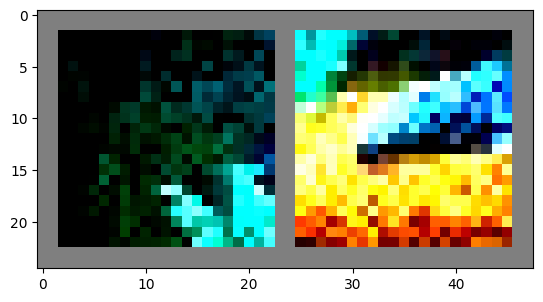

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


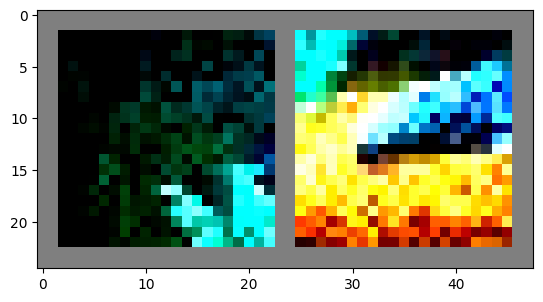

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


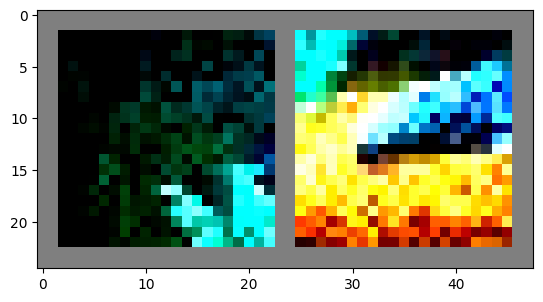

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


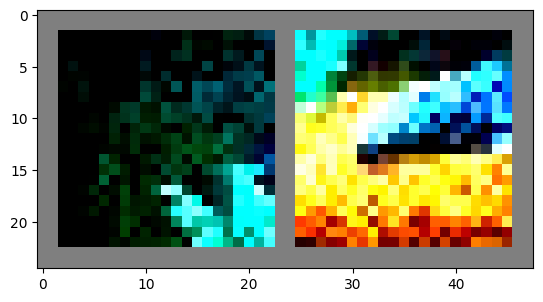

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


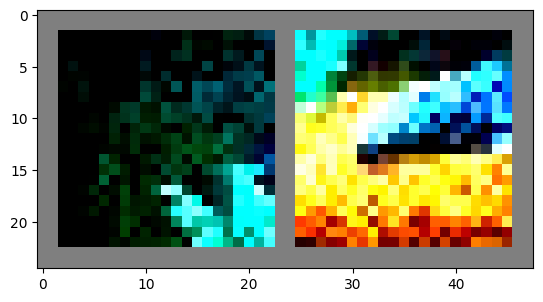

In [104]:
for X, y in dl:
    print(X.shape)
    print(y)
    for sample in X:
        for task in sample:
            imshow(torchvision.utils.make_grid(imgs))
    break